In [82]:
import random
import math
from functools import partial
from collections import namedtuple
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange, reduce
from einops.layers.torch import Rearrange
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.utils.data import TensorDataset


from tqdm import tqdm

random.seed(42)
np.random.seed(42)

# Params

In [83]:
seq_len = 15
epochs = 5
timesteps = 1000
batch_size = 32
latent_dim = 256
num_layers = 6
n_heads = 8    
beta_schedule = "linear"
objective = "pred_noise"

date = datetime.today().strftime('%Y-%m-%d-%H-%M_')
cond_model = "te"
log_file_name = f"transfusion_model_with_{cond_model}_conditioning_{str(date)}"

device = 'cuda' if torch.cuda.is_available() else 'cpu'


# Data

In [84]:
def normalize(data):
    
    min_val = np.min(np.min(data, axis=0), axis=0)
    data = data - min_val

    max_val = np.max(np.max(data, axis=0), axis=0)
    data = data / (max_val + 1e-7)
    
    data = data.astype(np.float32)
    
    return data

class MakeDATA(torch.utils.data.Dataset):
    def __init__(self, data, seq_len):
        
        data = np.asarray(data, dtype= np.float32)
        norm_data = normalize(data)

        seq_data = []
        for i in range(len(norm_data) - seq_len + 1):
            x = norm_data[i : i + seq_len]
            seq_data.append(x)

        self.samples = []
        idx = torch.randperm(len(seq_data))
        for i in range(len(seq_data)):
            self.samples.append(seq_data[idx[i]])
            
        self.samples = np.asarray(self.samples, dtype = np.float32)
            
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

def data_preprocess(subset_len=25000):
    
    data_dir = f'./data/LCL-June2015v2_0.csv'
    cond_data_dir = "./data/weather_hourly_darksky.csv"
    
    data = pd.read_csv(data_dir)
    data.replace('Null', 0, inplace=True)
    data = data.iloc[:subset_len, 3]
    
    cond_data = pd.read_csv(cond_data_dir)
    cond_data = cond_data[["time", "humidity", "temperature", "windSpeed"]]
    cond_data['time'] = pd.to_datetime(cond_data['time'])
    cond_data.set_index('time', inplace=True)
    cond_data = cond_data.resample('30min').interpolate(method='linear')    
    
    
    return data, cond_data

def LoadData(seq_len):
    tts_split = 0.8
    data, cond_data = data_preprocess() 
    data = MakeDATA(data, seq_len)
    cond_data = MakeDATA(cond_data, seq_len)
    train_data, test_data = train_test_split(data, train_size = tts_split, random_state = 2021)
    cond_data_train = cond_data[:len(train_data)]
    cond_data_test = cond_data[len(train_data):]
    return train_data, test_data, cond_data_train, cond_data_test

In [85]:
train_data, test_data, cond_data_train, cond_data_test = LoadData(seq_len=seq_len)
train_data, test_data, cond_data_train, cond_data_test= np.asarray(train_data), np.asarray(test_data), np.asarray(cond_data_train), np.asarray(cond_data_test) 

if len(train_data.shape) < 3:
    train_data = np.expand_dims(train_data, axis=-1)
    test_data = np.expand_dims(test_data, axis=-1)

features = train_data.shape[2]
cond_features = cond_data_train.shape[2]
print(f"num of channels in transformer: {features} \nnum of cond feature: {cond_features}")

train_data, test_data, cond_data_train, cond_data_test = train_data.transpose(0,2,1), test_data.transpose(0,2,1), cond_data_train.transpose(0,2,1), cond_data_test.transpose(0,2,1)
print(f"Train shape (batch, features, seq_len): {train_data.shape}")
print(f"Cond shape (batch, features, seq_len): {cond_data_train.shape}")


train_dataset = TensorDataset(torch.from_numpy(train_data), torch.from_numpy(cond_data_train))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size)

test_loader = torch.utils.data.DataLoader(test_data, len(test_data))

real_data, real_cond_data = next(iter(train_loader))
print(f"batched data shape: {real_data.shape}")

num of channels in transformer: 1 
num of cond feature: 3
Train shape (batch, features, seq_len): (19988, 1, 15)
Cond shape (batch, features, seq_len): (19988, 3, 15)
batched data shape: torch.Size([32, 1, 15])


# Model
## Embeddings

In [86]:
class TimestepEmbedder(nn.Module):
    def __init__(self, latent_dim, sequence_pos_encoder):
        super().__init__()
        self.latent_dim = latent_dim
        self.sequence_pos_encoder = sequence_pos_encoder

        time_embed_dim = self.latent_dim
        self.time_embed = nn.Sequential(
            nn.Linear(self.latent_dim, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, time_embed_dim),
        )

    def forward(self, timesteps):
        return self.time_embed(self.sequence_pos_encoder.pe[timesteps]).permute(1, 0, 2)
    
    
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)

        self.register_buffer('pe', pe)

    def forward(self, x):
        # not used in the final model
        x = x + self.pe[:x.shape[0], :]
        return self.dropout(x)

In [87]:
class MLPConditionalEmbedding(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
    
    def forward(self, x):
        #print(f"Shape x: {x.shape}")
        x = self.fc1(x)
        #print(f"Shape after fc1: {x.shape}")
        x = self.leaky_relu(x)
        x = self.fc2(x)
        #print(f"Shape after fc2: {x.shape}")
        return x

In [88]:
class TEConditionalEmbedding(nn.Module):
    def __init__(self, features=3, latent_dim=256, num_heads=8, num_layers = 6, dropout = 0.1, activation = 'gelu', ff_size = 1024):
        super().__init__()
        self.channels = features
        self.latent_dim  = latent_dim
        self.num_heads = num_heads
        self.ff_size = ff_size
        self.activation = activation
        self.num_layers = num_layers
        self.dropout = dropout
        
        self.pos_enc = PositionalEncoding(self.latent_dim)
        self.input_dim = nn.Linear(self.channels, self.latent_dim)
        self.output_dim = nn.Linear(self.latent_dim, self.latent_dim)
        self.TransEncLayer = nn.TransformerEncoderLayer(d_model=self.latent_dim,
                                                  nhead=self.num_heads,
                                                  dim_feedforward=self.ff_size,
                                                  dropout=self.dropout,
                                                  activation=self.activation)
        
        self.TransEncodeR = nn.TransformerEncoder(self.TransEncLayer,
                                                     num_layers=self.num_layers)
        
    def forward(self, cond_input):
        #print(f"Input shape: {cond_input.shape}")
        cond_input = torch.transpose(cond_input, 1, 2)
        #print(f"Transposed shape: {cond_input.shape}")
        lin_out = self.input_dim(cond_input)
        #print(f"Input dim shape after linear: {lin_out.shape}")
        lin_out = torch.transpose(lin_out, 0, 1)
        #print(f"Input dim shape after transpose: {lin_out.shape}")
        
        pos_encoded = self.pos_enc(lin_out)
        #print(f"shape of pos enc: {pos_encoded.shape}")
        
        trans_output = self.TransEncodeR(pos_encoded)
        #print(f"Transformer Encoded output shape: {trans_output.shape}")
        
        final_output = self.output_dim(trans_output)
        #print(f"Transformer Encoded after linear output shape: {final_output.shape}")
        
        transposed_data = final_output.permute(1, 2, 0)
        #print(f"Final output shape: {transposed_data.shape}")
        return transposed_data
        

## Transformer Encoder

In [89]:
class TransEncoder(nn.Module):
    
    def __init__(self, features, latent_dim=256, num_heads=8, num_layers = 6, cond_model = "mlp", cond_features = None ,dropout = 0.1, activation = 'gelu', ff_size = 1024):
        
        super().__init__()

        self.channels = features
        self.self_condition = None
        self.context_size = None
        self.latent_dim  = latent_dim
        self.num_heads = num_heads
        self.ff_size = ff_size
        self.activation = activation
        self.num_layers = num_layers
        self.dropout = dropout
                
        self.pos_enc = PositionalEncoding(self.latent_dim)
        self.emb_timestep = TimestepEmbedder(self.latent_dim, self.pos_enc)
        self.input_dim = nn.Linear(self.channels, self.latent_dim)
        #print(f"num of channels in transformer: {self.channels}")
        self.output_dim = nn.Linear(self.latent_dim, self.channels)
        self.TransEncLayer = nn.TransformerEncoderLayer(d_model=self.latent_dim,
                                                  nhead=self.num_heads,
                                                  dim_feedforward=self.ff_size,
                                                  dropout=self.dropout,
                                                  activation=self.activation)

        self.TransEncodeR = nn.TransformerEncoder(self.TransEncLayer,
                                                     num_layers=self.num_layers)
        
        self.cond_features = cond_features
        self.cond_model = cond_model
        assert self.cond_model in {"mlp", "te", "spectro"}, "Chosen conditioning model was not valid, the options are mlp, te and spectro"
        if cond_model == "mlp":
            self.conditional_embedding = MLPConditionalEmbedding(seq_len, latent_dim)
        if cond_model == "te":
            self.conditional_embedding = TEConditionalEmbedding(cond_features)
        
    def forward(self, x, t, cond_input = None):
        #print(f"Input shape: {x.shape}")
        x = torch.transpose(x, 1, 2)
        #print(f"Transposed shape: {x.shape}")
        x = self.input_dim(x)
        #print(f"Input dim shape after linear: {x.shape}")
        x = torch.transpose(x, 0, 1)
        #print(f"Input dim shape after transpose: {x.shape}")
        embed = self.emb_timestep(t)
        #print(f"Time embedding shape: {embed.shape}")
        time_added_data = torch.cat((embed, x), axis = 0)
        #print(f"Time added data shape: {time_added_data.shape}")
        time_added_data = self.pos_enc(time_added_data)
        #print(f"Time added data shape after pos enc: {time_added_data.shape}")
        trans_output = self.TransEncodeR(time_added_data)[1:]
        #print(f"Transformer Encoded output shape: {trans_output.shape}")
        
        if cond_input is not None:
            cond_emb = self.conditional_embedding(cond_input)
            #print(f"cond emb shape: {cond_emb.shape}")
            
            if self.cond_model == "mlp":
                cond_emb = cond_emb.permute(1,0,2)
            
            if self.cond_model == "te":
                cond_emb = cond_emb.permute(2,0,1)
                
            #print(f"Cond embed shape{cond_emb.shape}")
            
            combined = torch.cat([trans_output, cond_emb], dim=0)
            trans_output = combined[:15]
            #print(f"Combined transformer output shape: {trans_output.shape}")
        
        final_output = self.output_dim(trans_output)
        #print(f"Transformer Encoded after linear output shape: {final_output.shape}")
            
        transposed_data = final_output.permute(1, 2, 0)
        #print(f"Final output shape: {transposed_data.shape}")
        return transposed_data

## Model Diagnostics

In [90]:
sample, cond_data = next(iter(train_loader))

cond_data = cond_data.float()

batch, features, seq_len = sample.shape
t = torch.randint(0, 1000, (batch,)).long()

diagnostic_model =  TransEncoder(features=features, cond_model="te", cond_features=cond_features)

predicted_noise = diagnostic_model(sample, t, cond_data)

c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


# DDPM
## Helper functions

In [91]:
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if callable(d) else d

def identity(t, *args, **kwargs):
    return t

def cycle(dl):
    while True:
        for data in dl:
            yield data

def has_int_squareroot(num):
    return (math.sqrt(num) ** 2) == num

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

def convert_image_to_fn(img_type, image):
    if image.mode != img_type:
        return image.convert(img_type)
    return image

# normalization functions

def normalize_to_neg_one_to_one(img):
    return img * 2 - 1

def unnormalize_to_zero_to_one(t):
    return (t + 1) * 0.5

def extract(a, t, x_shape):
    b, *_ = t.shape
    out = a.gather(-1, t)
    return out.reshape(b, *((1,) * (len(x_shape) - 1)))

ModelPrediction =  namedtuple('ModelPrediction', ['pred_noise', 'pred_x_start'])



## GaussianDiffusion1D

In [92]:
def linear_beta_schedule(timesteps):
    scale = 1000 / timesteps
    beta_start = scale * 0.0001
    beta_end = scale * 0.02
    return torch.linspace(beta_start, beta_end, timesteps, dtype = torch.float64)

In [93]:
class GaussianDiffusion1D(nn.Module):
    def __init__(
        self,
        model,
        *,
        seq_length,
        timesteps = 1000,
        sampling_timesteps = None,
        loss_type = 'l1',
        objective = 'pred_noise',
        beta_schedule = 'cosine',
        p2_loss_weight_gamma = 0.,
        p2_loss_weight_k = 1,
        ddim_sampling_eta = 1.
    ):
        super().__init__()
        self.model = model
        self.channels = self.model.channels
        self.self_condition = self.model.context_size
        self.seq_length = seq_length
        self.objective = objective

        assert objective in {'pred_noise', 'pred_x0', 'pred_v'}, 'objective must be either pred_noise (predict noise) or pred_x0 (predict image start) or pred_v (predict v [v-parameterization as defined in appendix D of progressive distillation paper, used in imagen-video successfully])'

        if beta_schedule == 'linear':
            betas = linear_beta_schedule(timesteps)

        alphas = 1. - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)
        alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value = 1.)

        timesteps, = betas.shape
        self.num_timesteps = int(timesteps)
        self.loss_type = loss_type

        # sampling related parameters

        self.sampling_timesteps = default(sampling_timesteps, timesteps) # default num sampling timesteps to number of timesteps at training

        assert self.sampling_timesteps <= timesteps
        self.is_ddim_sampling = self.sampling_timesteps < timesteps
        self.ddim_sampling_eta = ddim_sampling_eta

        # helper function to register buffer from float64 to float32

        register_buffer = lambda name, val: self.register_buffer(name, val.to(torch.float32))

        register_buffer('betas', betas)
        register_buffer('alphas_cumprod', alphas_cumprod)
        register_buffer('alphas_cumprod_prev', alphas_cumprod_prev)

        # calculations for diffusion q(x_t | x_{t-1}) and others

        register_buffer('sqrt_alphas_cumprod', torch.sqrt(alphas_cumprod))
        register_buffer('sqrt_one_minus_alphas_cumprod', torch.sqrt(1. - alphas_cumprod))
        register_buffer('log_one_minus_alphas_cumprod', torch.log(1. - alphas_cumprod))
        register_buffer('sqrt_recip_alphas_cumprod', torch.sqrt(1. / alphas_cumprod))
        register_buffer('sqrt_recipm1_alphas_cumprod', torch.sqrt(1. / alphas_cumprod - 1))

        # calculations for posterior q(x_{t-1} | x_t, x_0)

        posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

        # above: equal to 1. / (1. / (1. - alpha_cumprod_tm1) + alpha_t / beta_t)

        register_buffer('posterior_variance', posterior_variance)

        # below: log calculation clipped because the posterior variance is 0 at the beginning of the diffusion chain

        register_buffer('posterior_log_variance_clipped', torch.log(posterior_variance.clamp(min =1e-20)))
        register_buffer('posterior_mean_coef1', betas * torch.sqrt(alphas_cumprod_prev) / (1. - alphas_cumprod))
        register_buffer('posterior_mean_coef2', (1. - alphas_cumprod_prev) * torch.sqrt(alphas) / (1. - alphas_cumprod))

        # calculate p2 reweighting

        register_buffer('p2_loss_weight', (p2_loss_weight_k + alphas_cumprod / (1 - alphas_cumprod)) ** -p2_loss_weight_gamma)

    def predict_start_from_noise(self, x_t, t, noise):
        return (
            extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t -
            extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * noise
        )

    def predict_noise_from_start(self, x_t, t, x0):
        return (
            (extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t - x0) / \
            extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape)
        )

    def predict_v(self, x_start, t, noise):
        return (
            extract(self.sqrt_alphas_cumprod, t, x_start.shape) * noise -
            extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape) * x_start
        )

    def predict_start_from_v(self, x_t, t, v):
        return (
            extract(self.sqrt_alphas_cumprod, t, x_t.shape) * x_t -
            extract(self.sqrt_one_minus_alphas_cumprod, t, x_t.shape) * v
        )

    def q_posterior(self, x_start, x_t, t):
        posterior_mean = (
            extract(self.posterior_mean_coef1, t, x_t.shape) * x_start +
            extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_variance = extract(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = extract(self.posterior_log_variance_clipped, t, x_t.shape)
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def model_predictions(self, x, t, cond_data, x_self_cond = None, clip_x_start = False):
        
        if cond_data is not None:
            model_output = self.model(x, t, cond_data)
        else:
            model_output = self.model(x, t)
            
        maybe_clip = partial(torch.clamp, min = -1., max = 1.) if clip_x_start else identity

        if self.objective == 'pred_noise':
            pred_noise = model_output
            x_start = self.predict_start_from_noise(x, t, pred_noise)
            x_start = maybe_clip(x_start)

        elif self.objective == 'pred_x0':
            x_start = model_output
            x_start = maybe_clip(x_start)
            pred_noise = self.predict_noise_from_start(x, t, x_start)

        elif self.objective == 'pred_v':
            v = model_output
            x_start = self.predict_start_from_v(x, t, v)
            x_start = maybe_clip(x_start)
            pred_noise = self.predict_noise_from_start(x, t, x_start)

        return ModelPrediction(pred_noise, x_start)

    def p_mean_variance(self, x, t, cond_data, x_self_cond = None, clip_denoised = True):
        preds = self.model_predictions(x, t, cond_data, x_self_cond)
        x_start = preds.pred_x_start

        if clip_denoised:
            x_start.clamp_(-1., 1.)

        model_mean, posterior_variance, posterior_log_variance = self.q_posterior(x_start = x_start, x_t = x, t = t)
        return model_mean, posterior_variance, posterior_log_variance, x_start

    @torch.no_grad()
    def p_sample(self, x, t: int, cond_data, x_self_cond = None, clip_denoised = True):
        b, *_, device = *x.shape, x.device
        batched_times = torch.full((x.shape[0],), t, device = x.device, dtype = torch.long)
        model_mean, _, model_log_variance, x_start = self.p_mean_variance(x = x, t = batched_times, cond_data=cond_data, x_self_cond = x_self_cond, clip_denoised = clip_denoised)
        noise = torch.randn_like(x) if t > 0 else 0. # no noise if t == 0
        pred_img = model_mean + (0.5 * model_log_variance).exp() * noise
        return pred_img, x_start

    @torch.no_grad()
    def p_sample_loop(self, shape, cond_data):
        batch, device = shape[0], self.betas.device

        img = torch.randn(shape, device=device)

        x_start = None

        for t in tqdm(reversed(range(0, self.num_timesteps)), desc = 'sampling loop time step', total = self.num_timesteps):
            self_cond = x_start if self.self_condition else None
            img, x_start = self.p_sample(img, t, cond_data, self_cond)

        img = unnormalize_to_zero_to_one(img)
        return img

    @torch.no_grad()
    def ddim_sample(self, shape, clip_denoised = True):
        batch, device, total_timesteps, sampling_timesteps, eta, objective = shape[0], self.betas.device, self.num_timesteps, self.sampling_timesteps, self.ddim_sampling_eta, self.objective

        times = torch.linspace(-1, total_timesteps - 1, steps=sampling_timesteps + 1)   # [-1, 0, 1, 2, ..., T-1] when sampling_timesteps == total_timesteps
        times = list(reversed(times.int().tolist()))
        time_pairs = list(zip(times[:-1], times[1:])) # [(T-1, T-2), (T-2, T-3), ..., (1, 0), (0, -1)]

        img = torch.randn(shape, device = device)

        x_start = None

        for time, time_next in tqdm(time_pairs, desc = 'sampling loop time step'):
            time_cond = torch.full((batch,), time, device=device, dtype=torch.long)
            self_cond = x_start if self.self_condition else None
            pred_noise, x_start, *_ = self.model_predictions(img, time_cond, self_cond, clip_x_start = clip_denoised)

            if time_next < 0:
                img = x_start
                continue

            alpha = self.alphas_cumprod[time]
            alpha_next = self.alphas_cumprod[time_next]

            sigma = eta * ((1 - alpha / alpha_next) * (1 - alpha_next) / (1 - alpha)).sqrt()
            c = (1 - alpha_next - sigma ** 2).sqrt()

            noise = torch.randn_like(img)

            img = x_start * alpha_next.sqrt() + \
                  c * pred_noise + \
                  sigma * noise

        img = unnormalize_to_zero_to_one(img)
        return img

    @torch.no_grad()
    def sample(self, batch_size = 16, cond_data=None):
        seq_length, channels = self.seq_length, self.channels
        sample_fn = self.p_sample_loop if not self.is_ddim_sampling else self.ddim_sample
        return sample_fn((batch_size, channels, seq_length), cond_data)

    @torch.no_grad()
    def interpolate(self, x1, x2, t = None, lam = 0.5):
        b, *_, device = *x1.shape, x1.device
        t = default(t, self.num_timesteps - 1)

        assert x1.shape == x2.shape

        t_batched = torch.stack([torch.tensor(t, device = device)] * b)
        xt1, xt2 = map(lambda x: self.q_sample(x, t = t_batched), (x1, x2))

        img = (1 - lam) * xt1 + lam * xt2
        for i in tqdm(reversed(range(0, t)), desc = 'interpolation sample time step', total = t):
            img = self.p_sample(img, torch.full((b,), i, device=device, dtype=torch.long))

        return img

    def q_sample(self, x_start, t, noise=None):
        noise = default(noise, lambda: torch.randn_like(x_start))

        return (
            extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start +
            extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape) * noise
        )

    @property
    def loss_fn(self):
        if self.loss_type == 'l1':
            return F.l1_loss
        elif self.loss_type == 'l2':
            return F.mse_loss
        else:
            raise ValueError(f'invalid loss type {self.loss_type}')

    def p_losses(self, x_start, cond_data, t, noise = None):
        b, c, n = x_start.shape
        noise = default(noise, lambda: torch.randn_like(x_start))

        # noise sample

        x = self.q_sample(x_start = x_start, t = t, noise = noise)

        # if doing self-conditioning, 50% of the time, predict x_start from current set of times
        # and condition with unet with that
        # this technique will slow down training by 25%, but seems to lower FID significantly

        x_self_cond = None
        if self.self_condition and random() < 0.5:
            with torch.no_grad():
                x_self_cond = self.model_predictions(x, t).pred_x_start
                x_self_cond.detach_()

        # predict and take gradient step

        model_out = self.model(x, t, cond_data)

        if self.objective == 'pred_noise':
            target = noise
        elif self.objective == 'pred_x0':
            target = x_start
        elif self.objective == 'pred_v':
            v = self.predict_v(x_start, t, noise)
            target = v
        else:
            raise ValueError(f'unknown objective {self.objective}')

        loss = self.loss_fn(model_out, target, reduction = 'none')
        loss = reduce(loss, 'b ... -> b (...)', 'mean')

        loss = loss * extract(self.p2_loss_weight, t, loss.shape)
        return loss.mean()

    def forward(self, img, cond_data=None, *args, **kwargs):
        b, c, n, device, seq_length, = *img.shape, img.device, self.seq_length
        assert n == seq_length, f'seq length must be {seq_length}'
        t = torch.randint(0, self.num_timesteps, (b,), device=device).long()

        img = normalize_to_neg_one_to_one(img)
        
        # print(f'shape after normalizing: {img.shape}')
        return self.p_losses(img, cond_data, t, *args, **kwargs)

# Train

In [94]:
model = TransEncoder(features = features, latent_dim = latent_dim,num_heads = n_heads, num_layers = num_layers, cond_features=cond_features, cond_model="te")


diffusion = GaussianDiffusion1D(
        model,
        seq_length = seq_len,
        timesteps = timesteps,  
        objective = objective, # pred_x0, pred_v
        loss_type = 'l2',
        beta_schedule = beta_schedule
    )
    
diffusion = diffusion.to(device)

lr = 1e-4
betas = (0.9, 0.99)
optim = torch.optim.Adam(diffusion.parameters(), lr = lr, betas = betas)

In [95]:
for running_epoch in tqdm(range(epochs)):
    for i, (data, cond_data) in enumerate(train_loader):
        data = data.to(device)
        
        cond_data = cond_data.float()
        cond_data = cond_data.to(device)
        
        batch_size = data.shape[0]
        
        optim.zero_grad()
        
        #loss = diffusion(data, cond_data)
        loss = diffusion(data)
        loss.backward()
        
        optim.step()
    
    if i%len(train_loader)== 0 and running_epoch%10==0:
        print(f'Epoch: {running_epoch+1}, Loss: {loss.item()}')

100%|██████████| 5/5 [00:32<00:00,  6.59s/it]


# Sampling

In [96]:
with torch.no_grad():
    samples = diffusion.sample(len(test_data))
    samples = samples.cpu().numpy()
    samples = samples.transpose(0, 2, 1)

print(f"Samples shape: {samples.shape}")

sampling loop time step: 100%|██████████| 1000/1000 [01:48<00:00,  9.25it/s]


Samples shape: (4998, 15, 1)


# Evaluation
## Base

In [97]:
def visualize(ori_data, fake_data, seq_len, file_name):
    ori_data = np.asarray(ori_data)
    fake_data = np.asarray(fake_data)
    
    ori_data = ori_data[:fake_data.shape[0]]
    
    sample_size = 32
    idx = np.random.permutation(len(ori_data))[:sample_size]
    randn_num = np.random.permutation(sample_size)[:1]
    
    real_sample = ori_data[idx]
    fake_sample = fake_data[idx]
    
    real_sample_2d = real_sample.reshape(-1, seq_len)
    fake_sample_2d = fake_sample.reshape(-1, seq_len)
    
    ### PCA ###
    pca = PCA(n_components=2)
    pca.fit(real_sample_2d)
    pca_real = (pd.DataFrame(pca.transform(real_sample_2d))
                .assign(Data='Real'))
    pca_synthetic = (pd.DataFrame(pca.transform(fake_sample_2d))
                     .assign(Data='Synthetic'))
    pca_result = pd.concat([pca_real, pca_synthetic]).rename(
        columns={0: '1st Component', 1: '2nd Component'})
    
    ### TSNE ###
    tsne_data = np.concatenate((real_sample_2d, fake_sample_2d), axis=0)
    
    tsne = TSNE(n_components=2, verbose=0, perplexity=40)
    tsne_result = tsne.fit_transform(tsne_data)
    tsne_result = pd.DataFrame(tsne_result, columns=['X', 'Y']).assign(Data='Real')
    tsne_result.loc[len(real_sample_2d):, 'Data'] = 'Synthetic'
    
    fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12, 10))
    sb.scatterplot(x='1st Component', y='2nd Component', data=pca_result,
                   hue='Data', style='Data', ax=axs[0,0])
    sb.despine()
    axs[0,0].set_title('PCA Result')
    
    sb.scatterplot(x='X', y='Y', data=tsne_result, hue='Data', style='Data', ax=axs[0,1])
    sb.despine()
    axs[0,1].set_title('t-SNE Result')
    
    axs[1,0].plot(real_sample[randn_num[0], :, :].squeeze(), label='Original', color='blue')
    axs[1,0].set_title('Original Data')
    
    axs[1,1].plot(fake_sample[randn_num[0], :, :].squeeze(), label='Synthetic', color='red')
    axs[1,1].set_title('Synthetic Data')
    
    fig.suptitle('Assessing Diversity: Qualitative Comparison of Real and Synthetic Data Distributions', 
                 fontsize=14)
    fig.tight_layout()
    fig.subplots_adjust(top=.88)
    plt.savefig(f'./plots/{file_name}')
    plt.show()

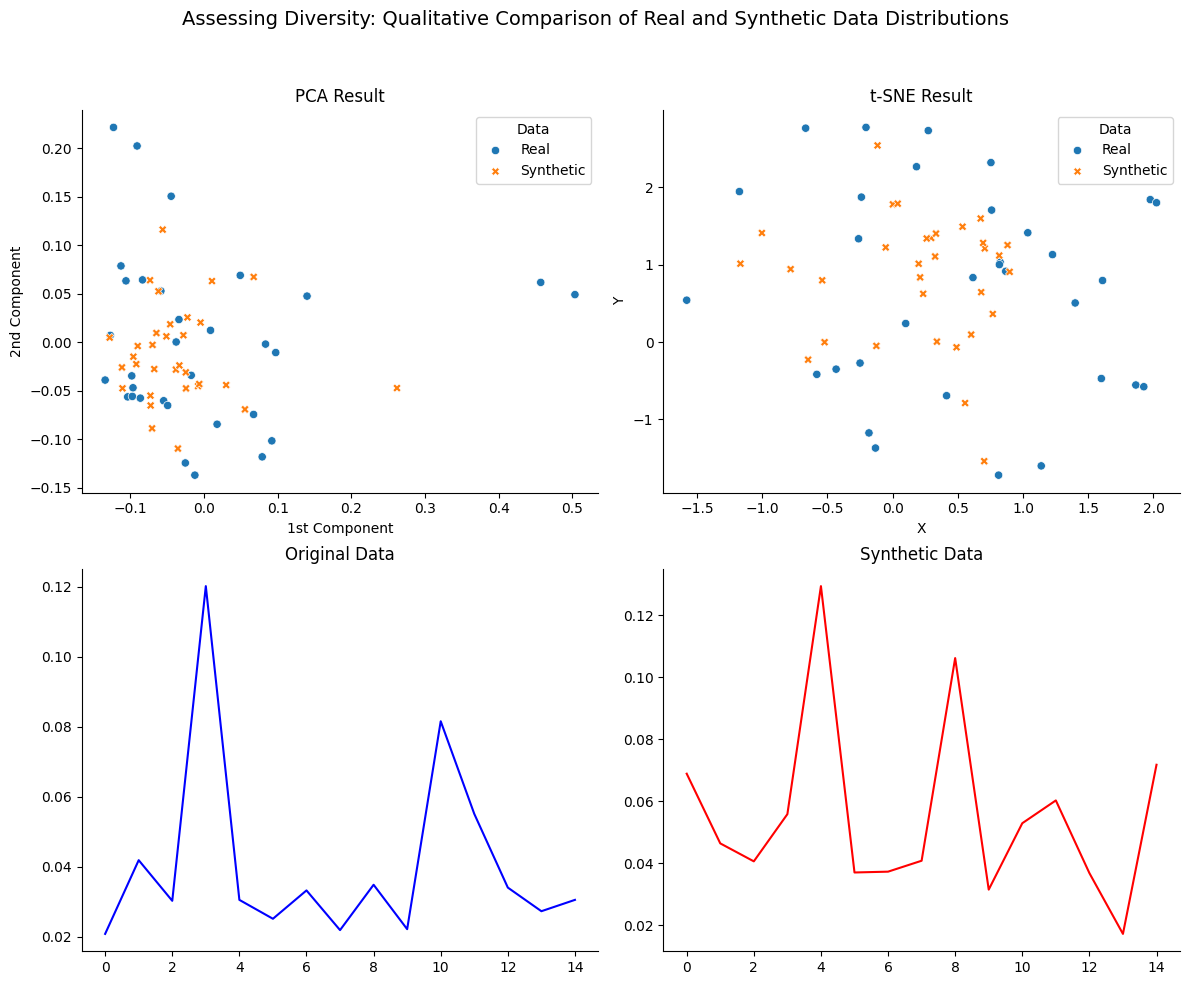

In [98]:
visualize(real_data.cpu().numpy().transpose(0,2,1), samples, seq_len, file_name=f"{log_file_name}_without_cond.jpg")

## With Conditioning

In [99]:
with torch.no_grad():
    cond_samples = diffusion.sample(32, real_cond_data.to(device))
    cond_samples = cond_samples.cpu().numpy()
    cond_samples = cond_samples.transpose(0, 2, 1)

print(f"Samples shape: {cond_samples.shape}")

sampling loop time step: 100%|██████████| 1000/1000 [00:06<00:00, 166.18it/s]

Samples shape: (32, 15, 1)


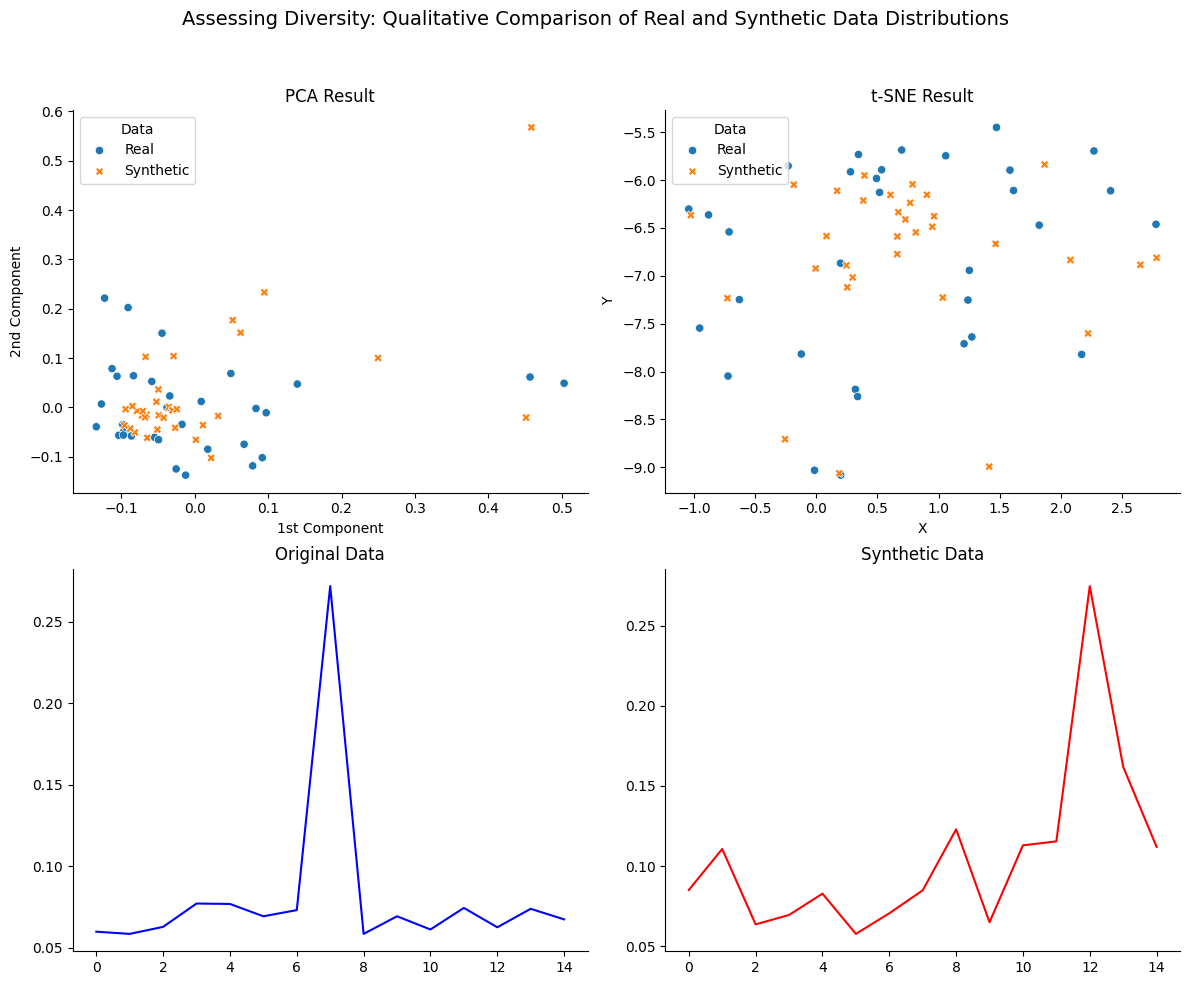

In [100]:
visualize(real_data.cpu().numpy().transpose(0,2,1), cond_samples, seq_len,  file_name=f"{log_file_name}_with_cond.jpg")